### Init

In [1]:
import os
import json
import glob
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from dateutil.parser import parse
load_dotenv()

## Initialize the environment variable for the use of OpenAI API Key
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
from langchain import LLMChain
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.agents import create_pandas_dataframe_agent , initialize_agent

In [2]:
df=sns.load_dataset("tips")[:20] 
full_df = sns.load_dataset("tips")
df.head(3)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3


In [47]:
def generate_prompt(query):
    
    prompt = (
        """
        Let's decode the way to respond to the query asked within the delimiter #. The responses depend on the type of information requested in the query.

        1. If the query requires a table, format your answer like this:
           {"table": {"columns": ["column1", "column2", ...], "data": [[value1, value2, ...], [value1, value2, ...], ...]}}

        2. For a bar chart, respond like this:
           {"bar": {"columns": ["A", "B", "C", ...], "data": [25, 24, 10, ...]}}

        3. If a line chart is more appropriate, your reply should look like this:
           {"line": {"columns": ["A", "B", "C", ...], "data": [25, 24, 10, ...]}}

        Note: We only accommodate two types of charts: "bar" and "line". 

        4. For a plain question that doesn't need a chart or table, your response should be:
           {"answer": "Your answer goes here"}

        For example:
           {"answer": "The Product with the highest Orders is '15143Exfo'"}

        5. If the answer is not known or available, respond with:
           {"answer": "I do not know."}

        Return all output as a string. Remember to encase all strings in the "columns" list and data list in double quotes.
        For example: {"columns": ["Products", "Orders"], "data": [["51993Masc", 191], ["49631Foun", 152]]}

        Do not create a new dataframe or rename the dataframe in the chain of thoughts. 
        Now, let's tackle the query step by step. Here's the query for you to work on:
        """
        + '#'+ query +'#'
    )

    return prompt


In [4]:
def create_plot(response_dict: dict):

    # Check if the response is an answer.
    if "answer" in response_dict:
        return response_dict["answer"]

    # Check if the response is a bar chart.
    if "bar" in response_dict:
        data = response_dict["bar"]
        try:
            plt.bar(data['columns'], data['data'])
            return plt.show()
        except ValueError:
            print(f"Couldn't create DataFrame from data: {data}")

    # Check if the response is a line chart.
    if "line" in response_dict:
        data = response_dict["line"]
        try:
            plt.line(data['columns'], data['data'])
            return plt.show()
        except ValueError:
            print(f"Couldn't create DataFrame from data: {data}")


    # Check if the response is a table.
    if "table" in response_dict:
        data = response_dict["table"]
        df = pd.DataFrame(data["data"], columns=data["columns"])
        return df

In [5]:
## return_intermediate_steps=True will let you access return the intermediate steps too
df_agent =  create_pandas_dataframe_agent(OpenAI(model='text-davinci-002',
                                                 temperature =0), df, verbose =True,
                                                 return_intermediate_steps=True)

# Run the prompt through the agent and capture the response.
query = 'create a bar chart showing the totat tips given by male and female'
prompt = generate_prompt(query)
response = df_agent(prompt)



> Entering new AgentExecutor chain...
Thought: I need to create a bar chart that shows the total tips given by male and female
Action: python_repl_ast
Action Input: df.groupby('sex').sum()['tip']
Observation: sex
Male      40.75
Female    17.81
Name: tip, dtype: float64
Thought:

<string>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


 I need to put this in the correct format
Final Answer: {"bar": {"columns": ["Male", "Female"], "data": [40.75, 17.81]}}

> Finished chain.


In [35]:
response_dict = json.loads(response['output'])
response_dict

{'bar': {'columns': ['Male', 'Female'], 'data': [40.75, 17.81]}}

In [33]:
df_query = response['intermediate_steps'][-1][0].log.split('\n')[-1].split('Action Input:')[-1].strip().replace("df","full_df")
query_result  = eval(df_query)
columns = list(query_result.index.categories)
values  = list(query_result.values)

<string>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


{'columns': ['Male', 'Female'], 'data': [485.07, 246.51]}

In [5]:
df = pd.read_csv('Timeseries data.csv')[:20]
full_df  =  pd.read_csv('Timeseries data.csv')

df['DATE'] = [pd.Timestamp(parse(df.loc[i].DATE)) for i in range(df.shape[0])]
# return_intermediate_steps=True will let you access return the intermediate steps too
# llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
llm =  OpenAI(model='text-davinci-003', temperature=0)
df_agent =  create_pandas_dataframe_agent(llm, df, verbose =True,return_intermediate_steps=True)




> Entering new AgentExecutor chain...

Thought: I need to create a line plot with the given data.

Action: python_repl_ast
Action Input: df.plot(x='DATE', y='IPG2211A2N', kind='line')
Observation: Axes(0.125,0.11;0.775x0.77)
Thought: I have created the line plot.
Final Answer: {"line": {"columns": ["DATE", "IPG2211A2N"], "data": [["1985-01-01 00:00:00", 72.5052], ["1985-02-01 00:00:00", 70.672], ["1985-03-01 00:00:00", 62.4502], ["1985-04-01 00:00:00", 57.4714], ["1985-05-01 00:00:00", 55.3151]]}}

> Finished chain.


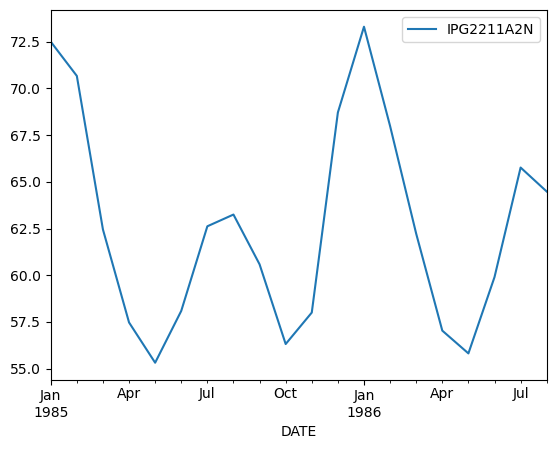

In [8]:
query = 'create a line plot with DATE on the x axis and values of IPG2211A2N column on the y axis'
prompt = generate_prompt(query)
response = df_agent(prompt)

In [7]:
response['intermediate_steps'][-1][0].log.split('\n')[-1].split('Action Input:')[-1].strip().replace("df","full_df")

"full_df.plot(x='DATE', y='IPG2211A2N', kind='line')"

In [9]:
response['intermediate_steps'][-1][0].log.split('\n')[-1].split('Action Input:')[-1].strip().replace("df","full_df")

"full_df.plot(x='DATE', y='IPG2211A2N', kind='line')"

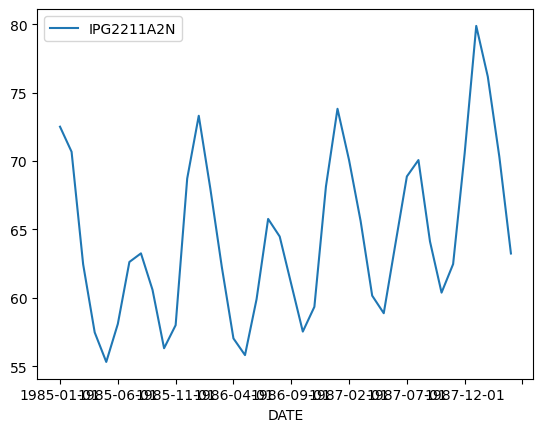

In [10]:
df_query = response['intermediate_steps'][-1][0].log.split('\n')[-1].split('Action Input:')[-1].strip().replace("df","full_df")
plot = eval(df_query)
plot = plot.get_figure()
plot.savefig('.\\plots\\plot.png')


### Test

In [58]:
def create_plot_2(file_, question ,df_query):
    full_df = pd.read_csv(file_)
    plot_dir = '.\\plots\\'
    # Check if the response is a bar chart.
    if "bar" in question.split(' '):
        query_result  = eval(df_query)
        columns = list(query_result.keys())
        values  = list(query_result.values())
        plt.bar(columns, values)
        fig_path = os.path.join(plot_dir, 'plot.png')
        plt.savefig(fig_path)
        
    # Check if the response is a line chart.
    if "line" in question.split(' '):
        fig_path = os.path.join(plot_dir, 'plot.png')
        plot = eval(df_query).get_figure()
        plot.savefig('.\\plots\\plot.png')
        
        plt.show()
        

In [61]:
def plotGenerator(file_ , question):
    df = pd.read_csv(file_).head(20)
    df['DATE'] = [pd.Timestamp(parse(df.loc[i].DATE)) for i in range(df.shape[0])]
    llm = OpenAI(model='text-davinci-003', temperature =0)
    df_agent =  create_pandas_dataframe_agent(llm, df, verbose =False,return_intermediate_steps=True)
    prompt = generate_prompt(question)
    response = df_agent(prompt)
    #response_dict = json.loads(response['output'])
    df_query = response['intermediate_steps'][-1][0].log.split('\n')[-1].split('Action Input:')[-1].strip().replace("df","full_df")
    print(df_query)
    files = glob.glob('.\\plots\\*')
    for f in files:
        os.remove(f)
    create_plot_2(file_,  question,df_query)
    return '.\\plots\\plot.png'
    

full_df[['DATE', 'IPG2211A2N']].values.tolist()


AttributeError: 'list' object has no attribute 'get_figure'

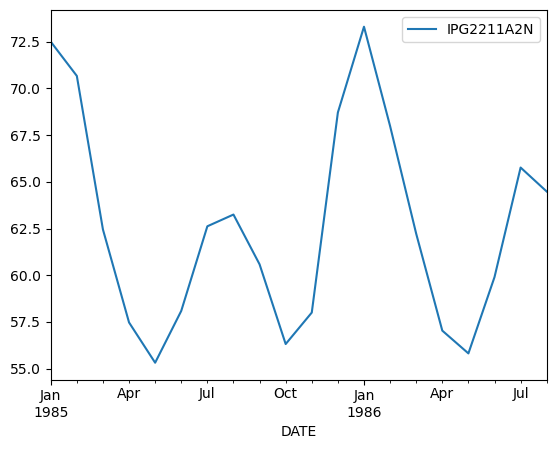

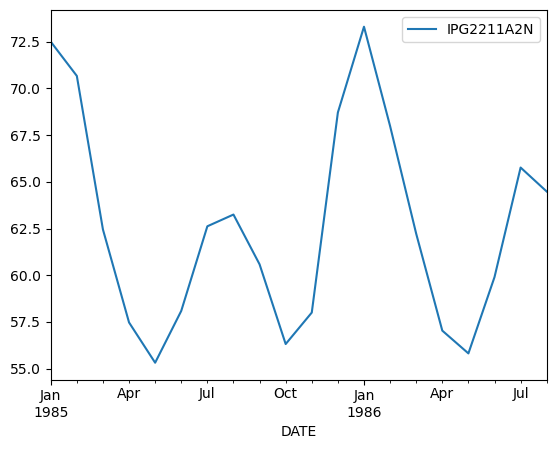

In [62]:
question = "create a line plot with DATE on the x axis and values of IPG2211A2N column on the y axis"
file = '.\\Timeseries data.csv'
res  = plotGenerator(file , question)


full_df.groupby('sex')['tip'].sum().to_dict()


AttributeError: 'dict' object has no attribute 'index'

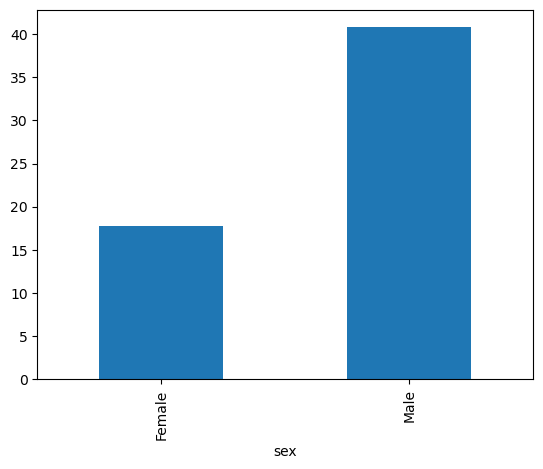

In [50]:
question = "create a bar chart showing the totat tips given by male and female"
file = '.\\tips.csv'
res  = plotGenerator(file , question)



> Entering new AgentExecutor chain...

Thought: I need to create a bar chart showing the total tips given by male and female
Action: python_repl_ast
Action Input: df.groupby('sex')['tip'].sum().plot.bar()
Observation: Axes(0.125,0.11;0.775x0.77)
Thought: I need to get the data from the bar chart
Action: python_repl_ast
Action Input: df.groupby('sex')['tip'].sum().to_dict()
Observation: {'Female': 17.81, 'Male': 40.75}
Thought: I now know the final answer
Final Answer: {"bar": {"columns": ["Female", "Male"], "data": [17.81, 40.75]}}

> Finished chain.


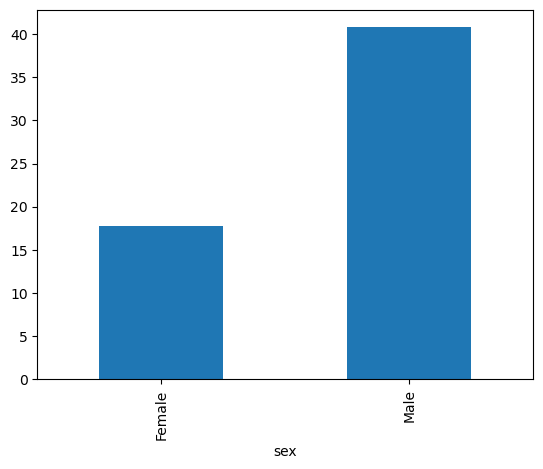

In [48]:
file = '.\\tips.csv'
df = pd.read_csv(file).head(20)
df_agent =  create_pandas_dataframe_agent(OpenAI(model='text-davinci-003',
                                                 temperature =0), df, verbose =True,
                                                 return_intermediate_steps=True)

# Run the prompt through the agent and capture the response.
query = 'create a bar chart showing the totat tips given by male and female'
prompt = generate_prompt(query)
response = df_agent(prompt)

In [49]:
response
response['intermediate_steps'][-1][0].log.split('\n')[-1].split('Action Input:')[-1].strip().replace("df","full_df")

"full_df.groupby('sex')['tip'].sum().to_dict()"

In [38]:
steps  = response['intermediate_steps']

In [43]:
for i in steps:
    print(i[0].log.split('\n')[-1].split('Action Input:')[-1].strip().replace("df","full_df"))

full_df.groupby('sex')['tip'].sum()
full_df_grouped = full_df.groupby('sex')['tip'].sum().reset_index()
full_df_grouped.to_dict('records')


In [46]:
eval('''
full_df.groupby('sex')['tip'].sum()
full_df_grouped = full_df.groupby('sex')['tip'].sum().reset_index()
full_df_grouped.to_dict('records')
''')

SyntaxError: invalid syntax (<string>, line 4)

In [54]:
full_df = pd.read_csv(file).head(20)
res = full_df.groupby('sex')['tip'].sum().to_dict()

In [57]:
list(res.values())

[17.81, 40.75]

In [66]:
print(df.head(10))

   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4
5       25.29  4.71    Male     No  Sun  Dinner     4
6        8.77  2.00    Male     No  Sun  Dinner     2
7       26.88  3.12    Male     No  Sun  Dinner     4
8       15.04  1.96    Male     No  Sun  Dinner     2
9       14.78  3.23    Male     No  Sun  Dinner     2
